
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online[![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.20.1?urlpath=lab/tree/tutorials/analysis/3D/flux_profiles.ipynb)
- You may download all the notebooks as a [tar file](../../../_downloads/notebooks-0.20.1.tar).
- **Source files:**
[flux_profiles.ipynb](../../../_static/notebooks/flux_profiles.ipynb) |
[flux_profiles.py](../../../_static/notebooks/flux_profiles.py)
</div>


# Flux Profile Estimation


This tutorial shows how to estimate flux profiles.

## Prerequisites

Knowledge of 3D data reduction and datasets used in Gammapy, see for instance the first analysis tutorial.


## Context
A useful tool to study and compare the saptial distribution of flux in images and data cubes is the measurement of flxu profiles. Flux profiles can show spatial correlations of gamma-ray data with e.g. gas maps or other type of gamma-ray data. Most commonly flux profiles are measured along some preferred coordinate axis, either radially distance from a source of interest, along longitude and latitude coordinate axes or along the path defined by two spatial coordinates. 

## Proposed Approach
Flux profile estimation essentially works by estimating flux points for a set of predefined spatially connected regions. For radial flux profiles the shape of the regions are annuli with a common center, for linear profiles it's typically a rectangular shape.

We will work on a pre-computed `MapDataset` of Fermi-LAT data, use `Region` to define the structure of the bins of the flux profile and run the actually profile extraction using the `FluxProfileEstimator` 


## Setup and Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
import numpy as np

In [2]:
from gammapy.datasets import MapDataset
from gammapy.estimators import FluxProfileEstimator, FluxPoints
from gammapy.maps import RegionGeom
from gammapy.utils.regions import (
    make_concentric_annulus_sky_regions,
    make_orthogonal_rectangle_sky_regions,
)
from gammapy.modeling.models import PowerLawSpectralModel

## Read and Introduce Data

In [3]:
dataset = MapDataset.read(
    "$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc.fits.gz", name="fermi-dataset"
)

This is what the counts image we will work with looks like:

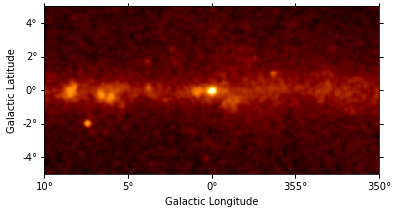

In [4]:
counts_image = dataset.counts.sum_over_axes()
counts_image.smooth("0.1 deg").plot(stretch="sqrt");

There are 400x200 pixels in the dataset and 11 energy bins between 10 GeV and 2 TeV:

In [5]:
print(dataset.counts)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (400, 200, 11)
	ndim  : 3
	unit  : 
	dtype : >i4



## Profile Estimation

### Configuration

We start by defining a list of spatially connected regions along the galactic longitude axis. For this there is a helper function `make_orthogonal_rectangle_sky_regions`. The individual region bins for the profile have a height of 3 deg and in total there are 31 bins. The starts from  lon = 10 deg tand goes to lon = 350 deg. In addition we have to specify the `wcs` to take into account possible projections effects on the region definition:

In [6]:
regions = make_orthogonal_rectangle_sky_regions(
    start_pos=SkyCoord("10d", "0d", frame="galactic"),
    end_pos=SkyCoord("350d", "0d", frame="galactic"),
    wcs=counts_image.geom.wcs,
    height="3 deg",
    nbin=51,
)

We can use the `RegionGeom` object to illustrate the regions on top of the counts image:

/Users/terrier/Code/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/regions/shapes/rectangle.py:206: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Rectangle(xy=xy, width=width, height=height,


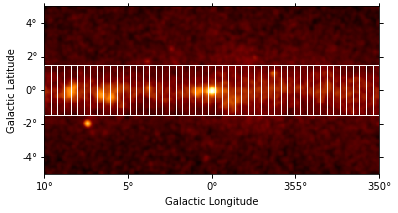

In [7]:
geom = RegionGeom.create(region=regions)
ax = counts_image.smooth("0.1 deg").plot(stretch="sqrt")
geom.plot_region(ax=ax, color="w");

Next we create the `FluxProfileEstimator`. For the estimation of the flux profile we assume a spectral model with a power-law shape and an index of 2.3

In [8]:
flux_profile_estimator = FluxProfileEstimator(
    regions=regions,
    spectrum=PowerLawSpectralModel(index=2.3),
    energy_edges=[10, 2000] * u.GeV,
    selection_optional=["ul"],
)

We can see the full configuration by printing the estimator object:

In [9]:
print(flux_profile_estimator)

FluxProfileEstimator
--------------------

  energy_edges           : [  10. 2000.] GeV
  fit                    : <gammapy.modeling.fit.Fit object at 0x146e7c070>
  n_sigma                : 1
  n_sigma_ul             : 2
  norm_max               : 5
  norm_min               : 0.2
  norm_n_values          : 11
  norm_values            : None
  null_value             : 0
  reoptimize             : False
  selection_optional     : ['ul']
  source                 : 0
  spectrum               : PowerLawSpectralModel
  sum_over_energy_groups : False



### Run Estimation
Now we can run the profile estimation and explore the results:

In [10]:
%%time
profile = flux_profile_estimator.run(datasets=dataset)

CPU times: user 48 s, sys: 721 ms, total: 48.7 s
Wall time: 1min


In [11]:
print(profile)

FluxPoints
----------

  geom                   : RegionGeom
  axes                   : ['lon', 'lat', 'energy', 'projected-distance']
  shape                  : (1, 1, 1, 51)
  quantities             : ['norm', 'norm_err', 'norm_ul', 'ts', 'npred', 'npred_excess', 'stat', 'counts', 'success']
  ref. model             : pl
  n_sigma                : 1
  n_sigma_ul             : 2
  sqrt_ts_threshold_ul   : 2
  sed type init          : likelihood



We can see the flux profile is represented by a `FluxPoints` object with a `projected-distance` axis, which defines the main axis the flux profile is measured along. The `lon` and `lat` axes can be ignored. 

### Plotting Results

Let us directly plot the result using `FluxPoints.plot()`:

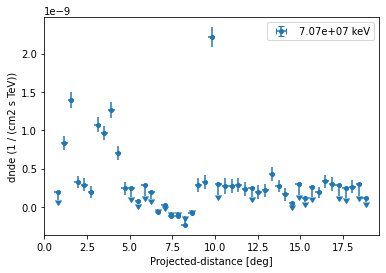

In [12]:
ax = profile.plot(sed_type="dnde")
ax.set_yscale("linear")

Based on the spectral model we specified above we can also plot in any other sed type, e.g. energy flux and define a different threshold when to plot upper limits:

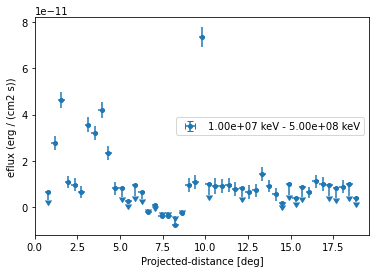

In [13]:
profile.sqrt_ts_threshold_ul = 2

ax = profile.plot(sed_type="eflux")
ax.set_yscale("linear")

We can also plot any other quantity of interest, that is defined on the `FluxPoints` result object. E.g. the predicted total counts, background counts and excess counts: 

Text(0, 0.5, 'Counts ')

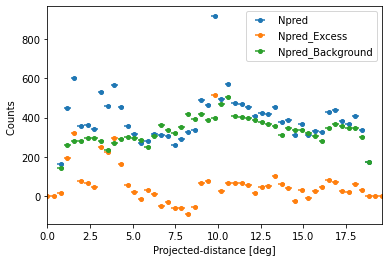

In [14]:
quantities = ["npred", "npred_excess", "npred_background"]

for quantity in quantities:
    profile[quantity].plot(label=quantity.title())

plt.ylabel("Counts ")

### Serialisation and I/O

The profile can be serialised using `FluxPoints.write()`, given a specific format:

In [15]:
profile.write(
    filename="flux_profile_fermi.fits",
    format="profile",
    overwrite=True,
    sed_type="dnde",
)

In [16]:
profile_new = FluxPoints.read(
    filename="flux_profile_fermi.fits", format="profile"
)

No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.


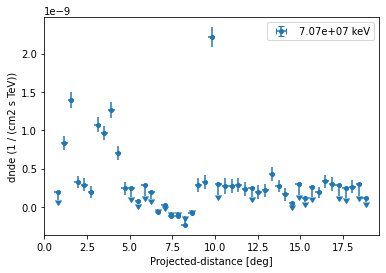

In [17]:
ax = profile_new.plot()
ax.set_yscale("linear")

The profile can be serialised to a `~astropy.table.Table` object using:

In [18]:
table = profile.to_table(format="profile", formatted=True)
table

x_min,x_max,x_ref,e_ref [1],e_min [1],e_max [1],ref_dnde [1],ref_flux [1],ref_eflux [1],norm [1],norm_err [1],norm_ul [1],ts [1],sqrt_ts [1],"npred [1,1]","npred_excess [1,1]",stat [1],is_ul [1],"counts [1,1]",success [1]
deg,deg,deg,keV,keV,keV,1 / (cm2 s TeV),keV / (cm2 s TeV),keV2 / (cm2 s TeV),,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,bool,float64,bool
-0.1960784313725492,0.1960784313725492,0.0,70710678.119,10000000.000,500000000.000,4.428e-10,3.043e-01,9.166e+06,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False
0.1960784313725492,0.5882352941176467,0.392156862745098,70710678.119,10000000.000,500000000.000,4.428e-10,3.043e-01,9.166e+06,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False
0.5882352941176467,0.9803921568627443,0.7843137254901955,70710678.119,10000000.000,500000000.000,4.428e-10,3.043e-01,9.166e+06,0.172,0.124,0.434,2.059,1.435,162.23048986115967,17.448376,-818.848,True,163.0,True
0.9803921568627443,1.3725490196078436,1.176470588235294,70710678.119,10000000.000,500000000.000,4.428e-10,3.043e-01,9.166e+06,1.894,0.207,2.322,120.591,10.981,450.20181889217974,192.60909,-3013.446,False,448.0,True
1.3725490196078436,1.764705882352942,1.5686274509803928,70710678.119,10000000.000,500000000.000,4.428e-10,3.043e-01,9.166e+06,3.146,0.240,3.639,280.648,16.753,601.6822045013222,320.15994,-4348.966,False,599.0,True
1.764705882352942,2.15686274509804,1.960784313725491,70710678.119,10000000.000,500000000.000,4.428e-10,3.043e-01,9.166e+06,0.736,0.183,1.116,18.991,4.358,357.6650304886396,74.95968,-2218.623,False,354.0,True
2.15686274509804,2.549019607843138,2.3529411764705888,70710678.119,10000000.000,500000000.000,4.428e-10,3.043e-01,9.166e+06,0.656,0.186,1.042,14.214,3.770,363.83338136609376,66.89659,-2452.717,False,367.0,True
2.549019607843138,2.941176470588236,2.745098039215687,70710678.119,10000000.000,500000000.000,4.428e-10,3.043e-01,9.166e+06,0.450,0.179,0.821,7.011,2.648,339.4818273314676,45.943058,-2174.005,False,339.0,True


No we can also estimate a radial profile starting from the Galactic center:

In [19]:
regions = make_concentric_annulus_sky_regions(
    center=SkyCoord("0d", "0d", frame="galactic"),
    radius_max="1.5 deg",
    nbin=11,
)

Again we first illustrate the regions:

/Users/terrier/Code/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/regions/core/compound.py:160: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = mpatches.PathPatch(path, **mpl_kwargs)


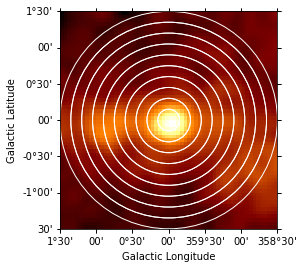

In [20]:
geom = RegionGeom.create(region=regions)
gc_image = counts_image.cutout(
    position=SkyCoord("0d", "0d", frame="galactic"), width=3 * u.deg
)
ax = gc_image.smooth("0.1 deg").plot(stretch="sqrt")
geom.plot_region(ax=ax, color="w");

This time we define two energy bins and include the fit statistic profile in the computation:

In [21]:
flux_profile_estimator = FluxProfileEstimator(
    regions=regions,
    spectrum=PowerLawSpectralModel(index=2.3),
    energy_edges=[10, 100, 2000] * u.GeV,
    selection_optional=["ul", "scan"],
    norm_values=np.linspace(-1, 5, 11),
)

In [22]:
profile = flux_profile_estimator.run(datasets=dataset)

We can directly plot the result:

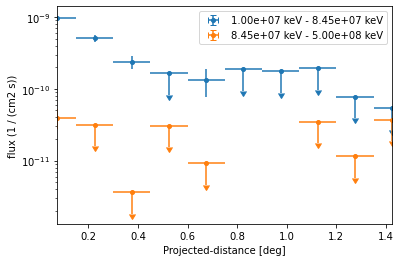

In [23]:
ax = profile.plot(axis_name="projected-distance", sed_type="flux")

However because of the powerlaw spectrum the flux at high energies is much lower. To extract the profile at high energies only we can use:

In [24]:
profile_high = profile.slice_by_idx({"energy": slice(1, 2)})

And now plot the points together with the likelihood profiles:

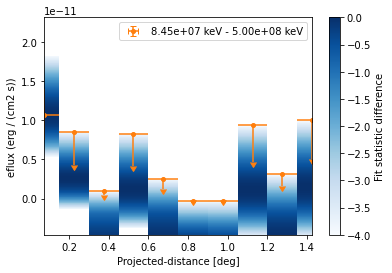

In [25]:
ax = profile_high.plot(sed_type="eflux", color="tab:orange")
profile_high.plot_ts_profiles(ax=ax, sed_type="eflux")
ax.set_yscale("linear")